# Sentiment Analysis Model

Link for Dataset https://autonlp.ai/datasets-list/sentiment-analysis-task

## Importing necessary libraries



In [ ]:
import re  
import gensim  
import numpy as np  
import pandas as pd  
import tensorflow as tf 
import matplotlib.pyplot as plt  

from tensorflow import keras  
from keras import layers 
from keras.models import Sequential 
from keras.utils import pad_sequences 
from keras.callbacks import ModelCheckpoint  
from keras.preprocessing.text import Tokenizer  
from sklearn.metrics import confusion_matrix  
from sklearn.model_selection import train_test_split  
from nltk.tokenize.treebank import TreebankWordDetokenizer  



## Reading the data from a TSV file

In [ ]:
data = pd.read_csv('smsa_train.tsv',sep='\t')
df = pd.DataFrame(data)
df.iloc[0] = ['text', 'value']  # Renaming column headers
df.columns = df.iloc[0]  # Assigning column headers
df = df[1:]  # Removing the first row (redundant column headers)
df.head(10)  # Displaying the first 10 rows of the dataframe

,text,value
1,lokasi strategis di jalan sumatera bandung . t...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative
4,"makanan beragam , harga makanan di food stall ...",positive
5,pakai kartu kredit bca tidak untung malah rugi...,negative
6,"tempat unik , bagus buat foto , makanan enak ,...",positive
7,saya bersama keluarga baru saja menikmati peng...,positive
8,bersyukur,positive
9,simcard indosat inaktiv gara-gara lupa isi pul...,negative
10,sifat iri sering muncul pada orang orang yang ...,negative


In [ ]:
df.groupby('value').nunique() # Grouping data by 'value' and finding unique counts

,text
value,
negative,3412
neutral,1137
positive,6382


In [ ]:
  # Checking for any null values in the 'text' column

0

## Data Cleaning

In [ ]:
# Function for data cleaning
def depure_data(data):

    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [ ]:
temp = []
# Convert pd.Series to list
data_to_list = df['text'].values.tolist()

# Iterate over each text sample and apply data cleaning
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['lokasi strategis di jalan sumatera bandung . tempat nya nyaman terutama sofa di lantai 2 . paella nya enak , sangat pas dimakan dengan minum bir dingin . appetiser nya juga enak-enak .',
 'betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus ! menetapkan beli lagi !',
 'duh . jadi mahasiswa jangan sombong dong . kasih kartu kuning segala . belajar dulu yang baik , tidak usahlah ikut-ikut politik . nanti sudah selesai kuliah nya mau ikut politik juga tidak telat . dasar mahasiswa .',
 'makanan beragam , harga makanan di food stall akan ditambahkan 10 % lagi di kasir , suasana ramai dan perlu perhatian untuk mendapatkan parkir dan tempat duduk .',
 'pakai kartu kredit bca tidak untung malah rugi besar']

## Text Preprocessing

In [ ]:
# Function for converting sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))
print(data_words[:10])

[['lokasi', 'strategis', 'di', 'jalan', 'sumatera', 'bandung', 'tempat', 'nya', 'nyaman', 'terutama', 'sofa', 'di', 'lantai', 'paella', 'nya', 'enak', 'sangat', 'pas', 'dimakan', 'dengan', 'minum', 'bir', 'dingin', 'appetiser', 'nya', 'juga', 'enak', 'enak'], ['betapa', 'bahagia', 'nya', 'diri', 'ini', 'saat', 'unboxing', 'paket', 'dan', 'barang', 'nya', 'bagus', 'menetapkan', 'beli', 'lagi'], ['duh', 'jadi', 'mahasiswa', 'jangan', 'sombong', 'dong', 'kasih', 'kartu', 'kuning', 'segala', 'belajar', 'dulu', 'yang', 'baik', 'tidak', 'usahlah', 'ikut', 'ikut', 'politik', 'nanti', 'sudah', 'selesai', 'kuliah', 'nya', 'mau', 'ikut', 'politik', 'juga', 'tidak', 'telat', 'dasar', 'mahasiswa'], ['makanan', 'beragam', 'harga', 'makanan', 'di', 'food', 'stall', 'akan', 'ditambahkan', 'lagi', 'di', 'kasir', 'suasana', 'ramai', 'dan', 'perlu', 'perhatian', 'untuk', 'mendapatkan', 'parkir', 'dan', 'tempat', 'duduk'], ['pakai', 'kartu', 'kredit', 'bca', 'tidak', 'untung', 'malah', 'rugi', 'besar'], 

## Text Detokenization

In [ ]:
# Function for detokenizing text
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['lokasi strategis di jalan sumatera bandung tempat nya nyaman terutama sofa di lantai paella nya enak sangat pas dimakan dengan minum bir dingin appetiser nya juga enak enak', 'betapa bahagia nya diri ini saat unboxing paket dan barang nya bagus menetapkan beli lagi', 'duh jadi mahasiswa jangan sombong dong kasih kartu kuning segala belajar dulu yang baik tidak usahlah ikut ikut politik nanti sudah selesai kuliah nya mau ikut politik juga tidak telat dasar mahasiswa', 'makanan beragam harga makanan di food stall akan ditambahkan lagi di kasir suasana ramai dan perlu perhatian untuk mendapatkan parkir dan tempat duduk', 'pakai kartu kredit bca tidak untung malah rugi besar']


In [ ]:
data = np.array(data)

## Label Encoding

In [ ]:
# Extract the labels from the dataframe and encode them
labels = np.array(df['value'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

## Data sequencing and splitting

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint


In [ ]:
# Tokenization and Padding
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)

print(tweets) # Displaying the tokenized and padded sequences

[[   0    0    0 ...   14    8    8]
 [   0    0    0 ...   51  212   57]
 [   0    0    0 ... 1846  487  460]
 ...
 [   0    0    0 ...    2  674 4869]
 [   0    0    0 ... 2916   32   11]
 [   0    0    0 ...   13    1   32]]


In [ ]:
print(labels)  # Displaying the label data

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

8248 2750 8248 2750


## Model Architecture

In [ ]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3,activation='softmax'))

model0.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', 
                              verbose=1,save_best_only=True, mode='auto',
                              period=1,save_weights_only=False)

history = model0.fit(X_train, y_train, epochs=5,
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint0])

Epoch 1/5
257/258 [============================>.] - ETA: 0s - loss: 0.9364 - accuracy: 0.5714
Epoch 1: val_accuracy improved from -inf to 0.61127, saving model to best_model0.hdf5
258/258 [==============================] - 18s 60ms/step - loss: 0.9359 - accuracy: 0.5719 - val_loss: 0.8741 - val_accuracy: 0.6113
Epoch 2/5
258/258 [==============================] - ETA: 0s - loss: 0.7374 - accuracy: 0.6777
Epoch 2: val_accuracy improved from 0.61127 to 0.75964, saving model to best_model0.hdf5
258/258 [==============================] - 14s 53ms/step - loss: 0.7374 - accuracy: 0.6777 - val_loss: 0.5720 - val_accuracy: 0.7596
Epoch 3/5
258/258 [==============================] - ETA: 0s - loss: 0.4917 - accuracy: 0.7903
Epoch 3: val_accuracy improved from 0.75964 to 0.78473, saving model to best_model0.hdf5
258/258 [==============================] - 14s 53ms/step - loss: 0.4917 - accuracy: 0.7903 - val_loss: 0.5230 - val_accuracy: 0.7847
Epoch 4/5
258/258 [==============================] -

## Model Validation

In [ ]:
best_model = keras.models.load_model("best_model0.hdf5")

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

86/86 - 1s - loss: 0.4657 - accuracy: 0.8218 - 1s/epoch - 13ms/step
Model accuracy:  0.8218181729316711


In [ ]:
predictions = best_model.predict(X_test) # Predicting on test data

86/86 [==============================] - 1s 11ms/step


## Training and Validation Performance

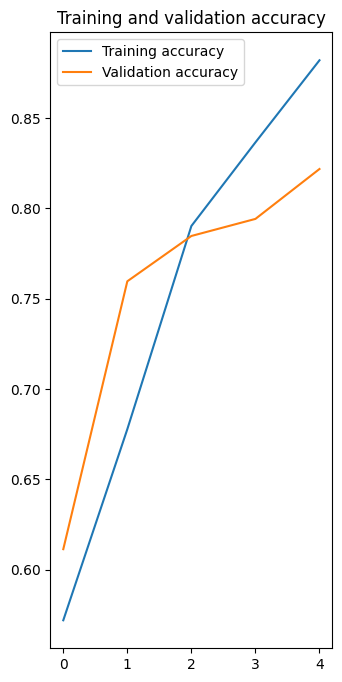

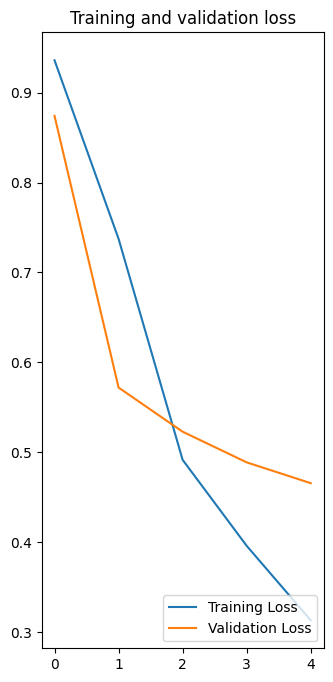

In [ ]:
def plot_loss_acc(history):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, label='Training accuracy')
  plt.plot(epochs, val_acc, label='Validation accuracy')
  plt.legend(loc='upper left')
  plt.title('Training and validation accuracy')

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend(loc='lower right')
  plt.title('Training and validation loss')
 
  plt.show()
# Plot training results
plot_loss_acc(history)
     

## Creating the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1),
                          np.around(predictions, decimals=0).argmax(axis=1))

<ipython-input-39-2aaca2b8a402>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


<Axes: >

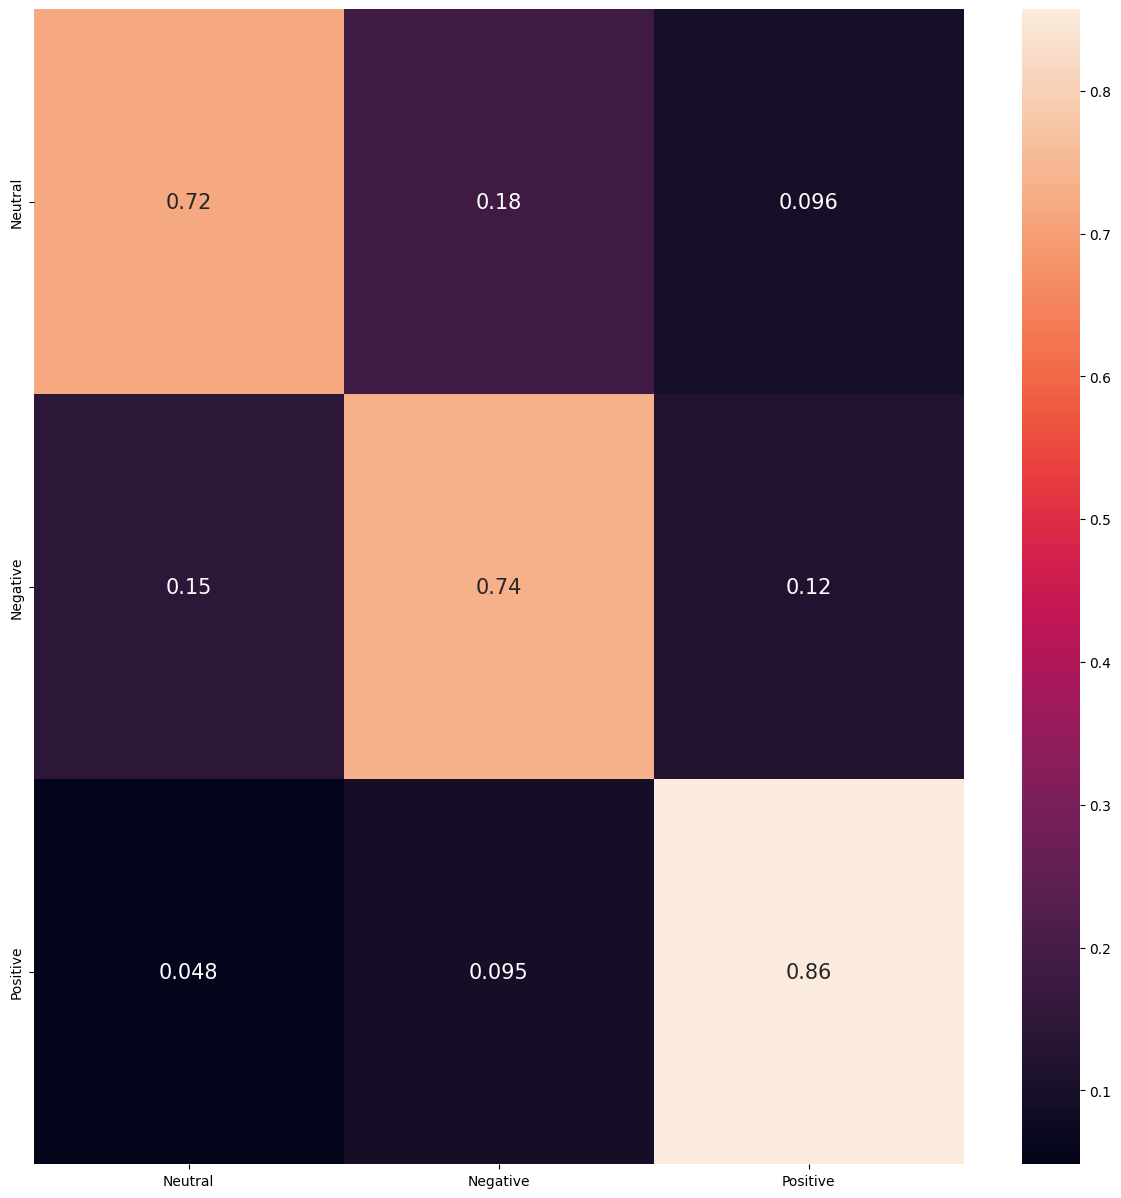

In [ ]:
# Plotting the confusion matrix
import seaborn as sns

conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],
                           columns = ['Neutral','Negative','Positive'])

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
# Predicting sentiment for a test sample
sentiment = ['Neutral','Negative','Positive']
sequence = tokenizer.texts_to_sequences(['Buku itu berwarna biru'])

test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), 
                    decimals=0).argmax(axis=1)[0]] 

1/1 [==============================] - 0s 47ms/step


'Neutral'


## Conversion and Downloading of TFLite Model



In [ ]:
import pathlib
from google.colab import files

export_dir = '/tmp/saved_model/'
tf.saved_model.save(best_model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('/tmp/ml_model.tflite')
tflite_model_file.write_bytes(tflite_model)

files.download(tflite_model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>